# Lab 5: time series forecast with AutoGluon

[AutoGluon](https://auto.gluon.ai/stable/index.html) is an open-source AutoML library that automates machine learning and deep learning for applications involving image, text, and tabular data. It enables users to quickly develop high-performance models with just a few lines of code by automating tasks like data preprocessing, model selection, hyperparameter tuning, and ensemble learning.

[AutoGluon Time Series](https://auto.gluon.ai/stable/tutorials/timeseries/index.html) can forecast the future values of multiple time series given the historical data and other related covariates. A single call to AutoGluon [`TimeSeriesPredictor`](https://auto.gluon.ai/stable/api/autogluon.timeseries.TimeSeriesPredictor.html)’s `fit()` method trains multiple models to generate accurate probabilistic forecasts, and does not require you to manually deal with cumbersome issues like model selection and hyperparameter tuning.

Under the hood, AutoGluon combines various state of the art forecasting algorithms. These include established statical methods like ETS and ARIMA from [`StatsForecast`](https://github.com/Nixtla/statsforecast), efficient tree-based forecasters like LightGBM based on [AutoGluon-Tabular](https://auto.gluon.ai/stable/tutorials/tabular/index.html), flexible deep learning models like [DeepAR](https://docs.aws.amazon.com/sagemaker/latest/dg/deepar.html) and Temporal Fusion Transformer from [GluonTS](https://ts.gluon.ai/), and a pretrained zero-shot forecasting model, [Chronos](https://github.com/amazon-science/chronos-forecasting). 

This workshop features DeepAR algorithm in the notebook [lab 3](./lab3_sagemaker_deepar.ipynb) and Chronos in the notebook [lab 4](./lab4_chronos.ipynb).

AutoGluon Time Series provides a robust and easy way to use Chronos through the `TimeSeriesPredictor` API. More specifically:
- Chronos can be combined with other forecasting models to build accurate ensembles using the `high_quality` and `best_quality` presets.
- Alternatively, Chronos can be used as a standalone zero-shot model with presets such as `"chronos_small"` or `"chronos_base"`.

For the full list of available time series algorithm used in AutoGluon refer to the [Model Zoo](https://auto.gluon.ai/stable/tutorials/timeseries/forecasting-model-zoo.html) page in the AutoGluon documentation.

This notebook demonstrate how to build time series forecast using AutoGluon Time Series API.

If you're not familiar with time series forecast, refer to [Forecasting Time Series in Depth](https://auto.gluon.ai/stable/tutorials/timeseries/forecasting-indepth.html) section in the AutoGluon documentation for more details and background.

## Import packages

In [ ]:
!rm -rf /opt/conda/lib/python3.10/site-packages/fsspec*
%pip install fsspec

In [ ]:
%pip install --upgrade autogluon
# %pip uninstall -q torchaudio torchvision torchtext # fix incompatible package versions on Colab
%pip install --upgrade pip sagemaker boto3 s3fs

In [71]:
%matplotlib inline

import json
import os
import boto3
import zipfile
from time import gmtime, strftime, sleep
import datetime
import sagemaker
import numpy as np
import pandas as pd
import tqdm
import torch
import autogluon
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import ipywidgets as widgets
from ipywidgets import (
interact, interactive, fixed, interact_manual,
IntSlider, FloatSlider, Checkbox, Dropdown, DatePicker, SelectMultiple
)

from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor

In [7]:
from importlib.metadata import version
print(version('autogluon'))

1.1.1


## Set literals and general variables

In [5]:
%store -r

In [8]:
sagemaker_session = sagemaker.Session()
region = sagemaker_session.boto_region_name
sm = boto3.client("sagemaker")

In [66]:
s3_bucket = sagemaker_session.default_bucket()  # replace with an existing bucket if needed
s3_prefix = "autogluon-demo-notebook"  # prefix used for all data stored within the bucket
experiment_prefix = "autogluon"
experiment_prefix_chronos = "autogluon-chronos"

sm_role = sagemaker.get_execution_role()  # IAM role to use by SageMaker

In [10]:
s3_data_path = f"s3://{s3_bucket}/{s3_prefix}/data"
s3_output_path = f"s3://{s3_bucket}/{s3_prefix}/output"

## Download the dataset

Download the from the SageMaker example S3 bucket. You use the [electricity dataset](https://archive.ics.uci.edu/ml/datasets/ElectricityLoadDiagrams20112014) from the repository of the University of California, Irvine:
> Trindade, Artur. (2015). ElectricityLoadDiagrams20112014. UCI Machine Learning Repository. https://doi.org/10.24432/C58C86.

In [12]:
dataset_zip_file_name = "LD2011_2014.txt.zip"
s3_dataset_path = f"datasets/timeseries/uci_electricity/{dataset_zip_file_name}"

In [13]:
os.makedirs("./data", exist_ok=True)

s3_client = boto3.client("s3")
s3_client.download_file(
    f"sagemaker-example-files-prod-{region}", s3_dataset_path, f"./data/{dataset_zip_file_name}"
)

In [14]:
zip_ref = zipfile.ZipFile(f"./data/{dataset_zip_file_name}", "r")
zip_ref.extractall("./data")
zip_ref.close()
dataset_path = '.'.join(zip_ref.filename.split('.')[:-1])

In [15]:
# see what is inside the file
# !head -n 2 {dataset_path} 

## Explore and preprocess data

In [16]:
df_raw = pd.read_csv(
    dataset_path, 
    sep=';', 
    index_col=0,
    decimal=',',
    parse_dates=True,
)

In [14]:
df_raw

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
2011-01-01 00:15:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-01-01 00:30:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-01-01 00:45:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-01-01 01:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-01-01 01:15:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-12-31 23:00:00,2.538071,22.048364,1.737619,150.406504,85.365854,303.571429,11.305822,282.828283,68.181818,72.043011,...,276.945039,28200.0,1616.033755,1363.636364,29.986962,5.851375,697.102722,176.961603,651.026393,7621.621622
2014-12-31 23:15:00,2.538071,21.337127,1.737619,166.666667,81.707317,324.404762,11.305822,252.525253,64.685315,72.043011,...,279.800143,28300.0,1569.620253,1340.909091,29.986962,9.947338,671.641791,168.614357,669.354839,6702.702703
2014-12-31 23:30:00,2.538071,20.625889,1.737619,162.601626,82.926829,318.452381,10.175240,242.424242,61.188811,74.193548,...,284.796574,27800.0,1556.962025,1318.181818,27.379400,9.362200,670.763828,153.589316,670.087977,6864.864865
2014-12-31 23:45:00,1.269036,21.337127,1.737619,166.666667,85.365854,285.714286,10.175240,225.589226,64.685315,72.043011,...,246.252677,28000.0,1443.037975,909.090909,26.075619,4.095963,664.618086,146.911519,646.627566,6540.540541


In [17]:
# resample to 2h intervals
freq = "2H"
div = 8 # 2 hours contain 8x 15 min intervals, you need to  delete the resampled value by 8
num_timeseries = df_raw.shape[1]
data_kw = df_raw.resample(freq).sum() / div
timeseries = []

for i in tqdm.trange(num_timeseries):
    timeseries.append(np.trim_zeros(data_kw.iloc[:, i], trim="f"))

100%|██████████| 370/370 [00:00<00:00, 1097.57it/s]


In [18]:
data_kw

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
2011-01-01 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-01-01 02:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-01-01 04:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-01-01 06:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-01-01 08:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-12-31 16:00:00,2.379442,28.538407,1.954822,160.569106,67.225610,260.416667,7.560769,352.693603,75.830420,53.897849,...,439.864383,40675.0,2816.983122,3980.113636,127.933507,7.753072,504.938543,118.948247,703.445748,12033.783784
2014-12-31 18:00:00,2.220812,28.449502,2.172024,208.587398,91.310976,385.788690,12.719050,359.427609,95.498252,84.408602,...,425.053533,43300.0,2793.776371,3454.545455,105.606258,5.266238,500.877963,47.787980,706.011730,9554.054054
2014-12-31 20:00:00,2.379442,24.004267,1.737619,174.288618,89.176829,330.357143,11.447145,292.508418,84.134615,75.806452,...,330.389008,39137.5,1676.160338,1857.954545,74.967405,4.169105,420.654083,131.886477,675.219941,8344.594595
2014-12-31 22:00:00,2.062183,21.692745,1.737619,161.331301,85.365854,311.383929,11.023177,251.262626,68.181818,72.446237,...,289.079229,31775.0,1591.244726,1303.977273,46.284224,7.533645,665.605795,178.422371,669.263196,7263.513514


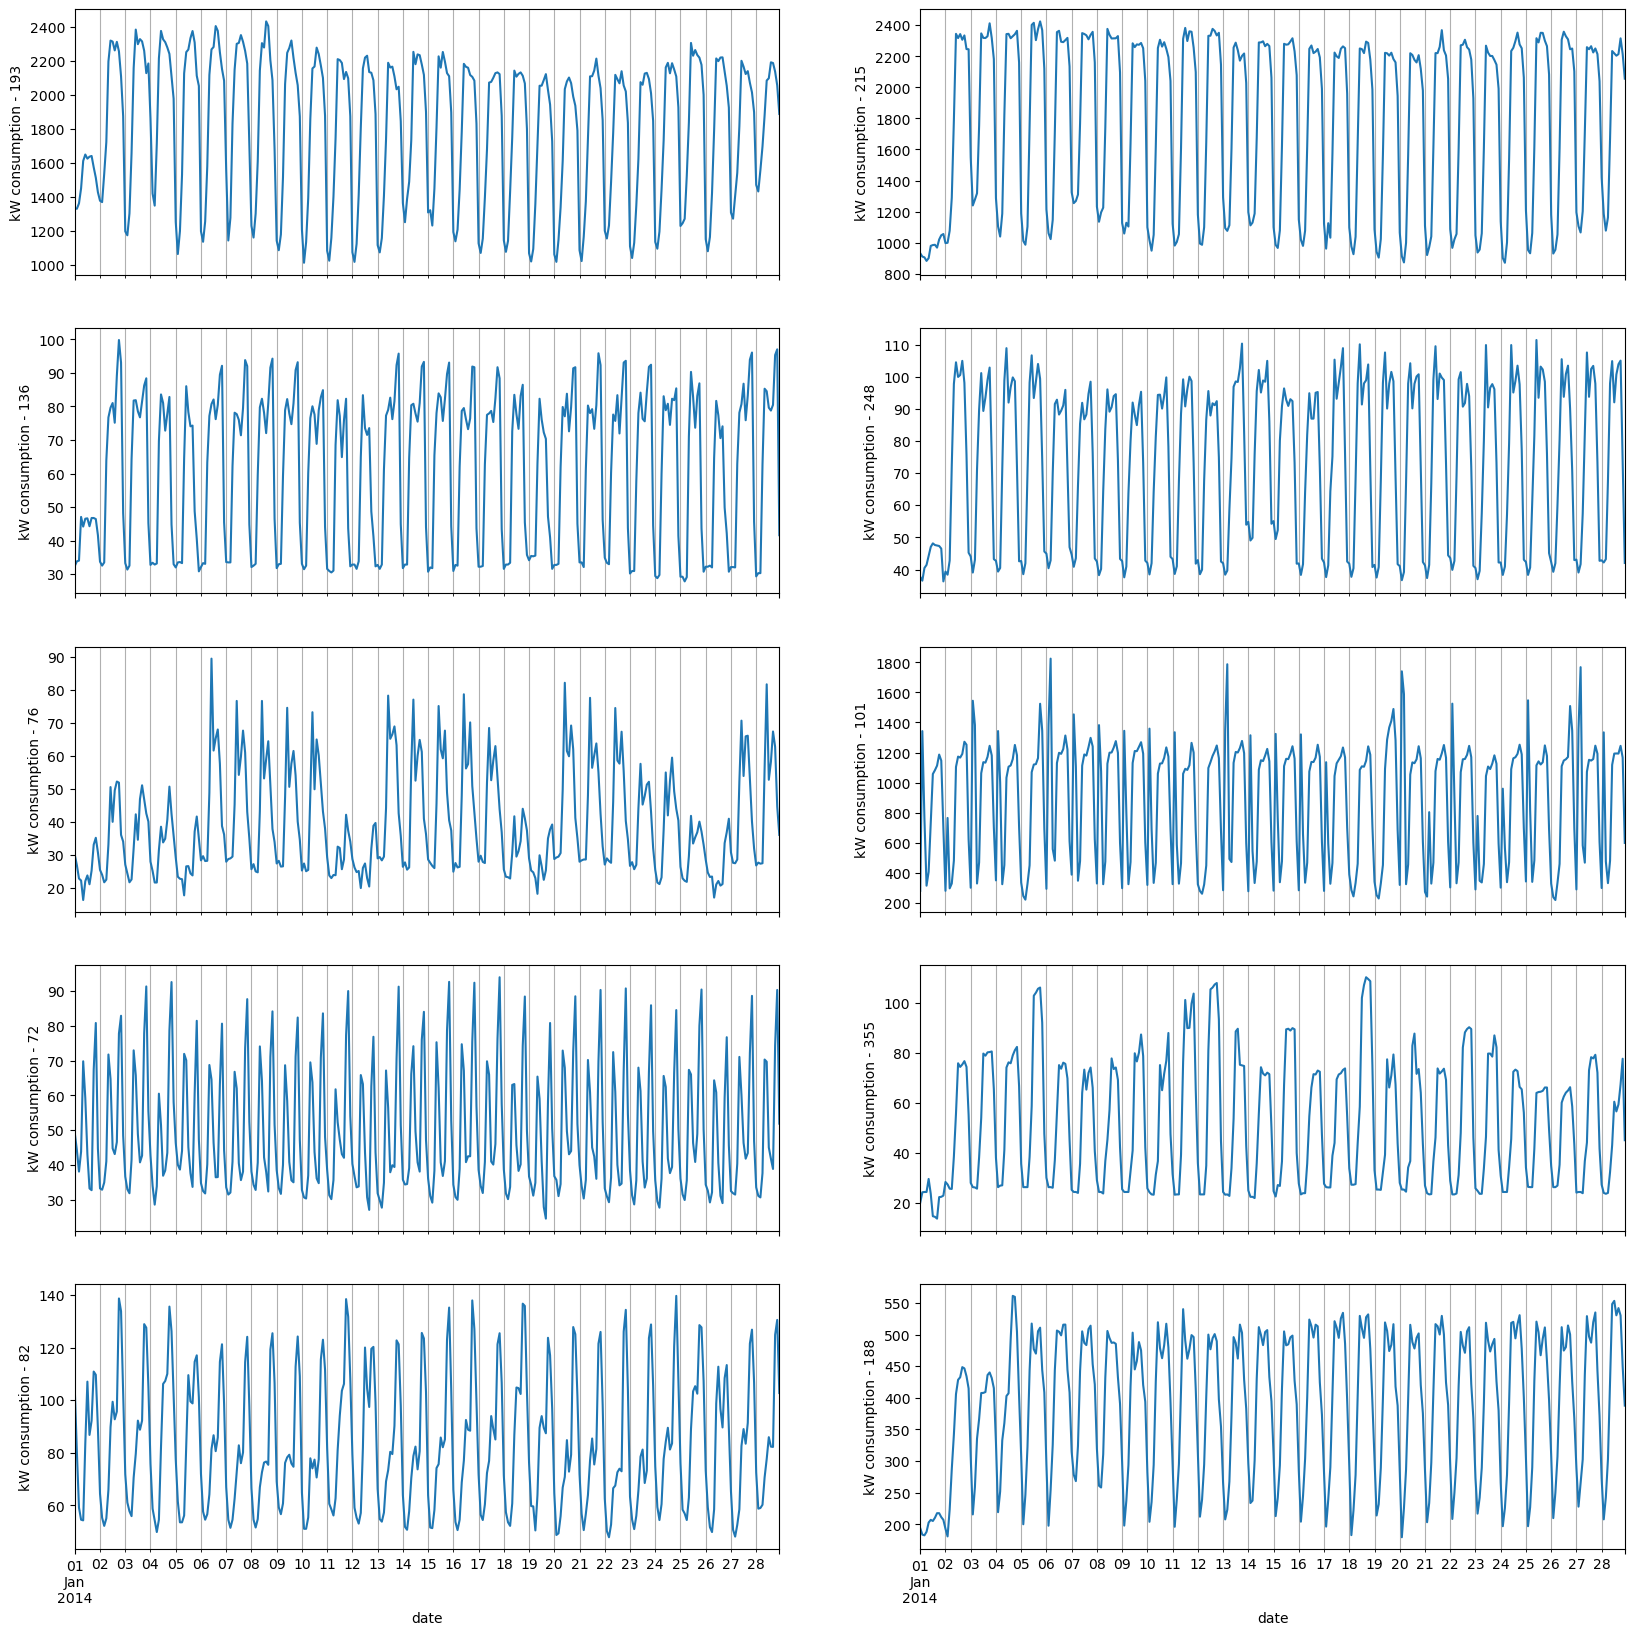

In [19]:
# show random 10 timeseries for 28 day period
fig, axs = plt.subplots(5, 2, figsize=(20, 20), sharex=True)
axx = axs.ravel()
for i, ts_id in enumerate(np.random.randint(1, data_kw.shape[1], size=10).tolist()):
    timeseries[ts_id].loc["2014-01-01":"2014-01-28"].plot(ax=axx[i])
    axx[i].set_xlabel("date")
    axx[i].set_ylabel(f"kW consumption - {ts_id}")
    axx[i].grid(which="minor", axis="x")

Create a smaller dataset with a subset of time series:

In [20]:
# select two random time series to include in a small dataset
size = 2
columns_to_keep = np.random.randint(1, data_kw.shape[1], size=size).tolist()
columns_to_keep

[261, 257]

In [21]:
data_kw_small = data_kw.iloc[:, columns_to_keep]
data_kw_small

,MT_262,MT_258
2011-01-01 00:00:00,87.231375,59.641167
2011-01-01 02:00:00,98.565544,65.764984
2011-01-01 04:00:00,104.299785,65.371648
2011-01-01 06:00:00,111.645774,66.949921
2011-01-01 08:00:00,121.862464,73.955047
...,...,...
2014-12-31 16:00:00,224.437679,145.803431
2014-12-31 18:00:00,200.363539,132.554219
2014-12-31 20:00:00,159.140401,81.060726
2014-12-31 22:00:00,122.757880,64.483438


## Train AutoGluon models

To start with AutoGluon you need:
1. Convert your time series dataset to a `TimeSeriesDataFrame`
2. Configure AutoGluon `TimeSeriesPredictor`
3. Fit models

This section takes you through these steps and produces a trained predictor.

Refere to the [AutoGluon Time Series - Forecasting Quick Start](https://auto.gluon.ai/stable/tutorials/timeseries/forecasting-quick-start.html) documentation for details on time series forecasting.

In [22]:
# predict for 7 days
prediction_days = 7
intervals_per_day = 12
prediction_length = prediction_days * intervals_per_day

print(f"Sampling frequency set to {freq}. Generate predictions for {prediction_length} intervals")

Sampling frequency set to 2H. Generate predictions for 84 intervals


### Convert dataset to AutoGluon format

AutoGluon expects time series data in [long format](https://doc.dataiku.com/dss/latest/time-series/data-formatting.html#long-format). Each row of the data frame contains a single observation (timestep) of a single time series represented by:
- unique ID of the time series (`"item_id"`) as int or str  
- timestamp of the observation (`"timestamp"`) as a `pandas.Timestamp` or compatible format
- numeric value of the time series (`"target"`)

Note, you can choose the names of the columns arbitrary, but need to specify the names when constructing a `TimeSeriesDataFrame` object.

<div class="alert alert-info">
To reduce the training time you can use a subset of time series instead of the full dataset with 370 time series.
</div>

For AWS-led workshop please choose a small dataset by leaving the `USE_FULL_DATASET` on it's default value `False`. The training time for the small dataset is about 5-12 minutes depending on the used JupyterLab App instance. The train time for the full dataset is about 40-70 minutes depending on the instance type. See the section **Train models** for more data points on training times on different SageMaker instances.

In [23]:
USE_FULL_DATASET = False

In [24]:
if USE_FULL_DATASET:
    ts_wide_df = data_kw
else:
    ts_wide_df = data_kw_small

In [25]:
# Melt the DataFrame
melted_df = pd.melt(
    ts_wide_df.reset_index(),
    id_vars='index', 
    value_vars=ts_wide_df.columns, 
    var_name='item_id', 
    value_name='target'
)

# Rename the 'index' column to 'timestamp'
melted_df = melted_df.rename(columns={'index': 'timestamp'})

print(melted_df)

                timestamp item_id      target
0     2011-01-01 00:00:00  MT_262   87.231375
1     2011-01-01 02:00:00  MT_262   98.565544
2     2011-01-01 04:00:00  MT_262  104.299785
3     2011-01-01 06:00:00  MT_262  111.645774
4     2011-01-01 08:00:00  MT_262  121.862464
...                   ...     ...         ...
35061 2014-12-31 16:00:00  MT_258  145.803431
35062 2014-12-31 18:00:00  MT_258  132.554219
35063 2014-12-31 20:00:00  MT_258   81.060726
35064 2014-12-31 22:00:00  MT_258   64.483438
35065 2015-01-01 00:00:00  MT_258    6.025237

[35066 rows x 3 columns]


Use the [`TimeSeriesDataFrame`](https://auto.gluon.ai/stable/api/autogluon.timeseries.TimeSeriesDataFrame.html) classs to convert a Pandas DataFrame to AutoGluon time series Data Frame.

In [26]:
ts_df = TimeSeriesDataFrame.from_data_frame(
    melted_df,
    id_column="item_id",
    timestamp_column="timestamp",
)

In [27]:
ts_df

target
item_id timestamp                      
MT_262  2011-01-01 00:00:00   87.231375
        2011-01-01 02:00:00   98.565544
        2011-01-01 04:00:00  104.299785
        2011-01-01 06:00:00  111.645774
        2011-01-01 08:00:00  121.862464
...                                 ...
MT_258  2014-12-31 16:00:00  145.803431
        2014-12-31 18:00:00  132.554219
        2014-12-31 20:00:00   81.060726
        2014-12-31 22:00:00   64.483438
        2015-01-01 00:00:00    6.025237

[35066 rows x 1 columns]

Note that AutoGluon generates forecasts for each time series individually, without modeling interactions between different items/time series. 

### Split the dataset to train and test
Split the dataset. The train dataset contains the slice `[:-prediction_length]` for each time series. The test dataset contains full time series for each item.

In [28]:
train_df, test_df = ts_df.train_test_split(prediction_length)

In [29]:
train_df.tail()

target
item_id timestamp                      
MT_258  2014-12-24 16:00:00  145.309543
        2014-12-24 18:00:00  112.285095
        2014-12-24 20:00:00   82.933754
        2014-12-24 22:00:00   64.878746
        2014-12-25 00:00:00   54.814669

In [30]:
test_df.tail()

target
item_id timestamp                      
MT_258  2014-12-31 16:00:00  145.803431
        2014-12-31 18:00:00  132.554219
        2014-12-31 20:00:00   81.060726
        2014-12-31 22:00:00   64.483438
        2015-01-01 00:00:00    6.025237

### Fit models

Use the AutoGluon [`TimeSeriesPredictor`](https://auto.gluon.ai/stable/api/autogluon.timeseries.TimeSeriesPredictor.html) class to train models and do inference.

`TimeSeriesPredictor` provides probabilistic (quantile) multi-step-ahead forecasts for **univariate time series**. The forecast includes both the mean - conditional expectation of future values given the past, as well as the quantiles of the forecast distribution, indicating the range of possible future outcomes.

`TimeSeriesPredictor` fits both _global_ deep learning models that are shared across all time series such as DeepAR, Transformer, as well as _local_ statistical models that are fit to each individual time series such as ARIMA, ETS.

You can include covariates known as dynamic features, exogenous variables, additional regressors or related time series into training. Examples of such covariates include holidays, promotions or weather forecasts. See the AutoGluon documentation for more details and examples.

In [31]:
timestamp = strftime("%Y%m%d-%H%M%S", gmtime())
experiment_name = f"{experiment_prefix}-{freq}-{ts_wide_df.shape[1]}-{ts_wide_df.shape[0]}"
eval_metric = 'WQL'
forecast_quantiles = [0.1, 0.5, 0.9]
predictor_data_path = f"{experiment_name}-{timestamp}"

In [32]:
start_dataset = test_df.index.get_level_values(1)[0]
end_dataset = test_df.index.get_level_values(1)[-1]

In [33]:
predictor = TimeSeriesPredictor(
    target="target",
    prediction_length=prediction_length,
    eval_metric=eval_metric,
    quantile_levels=forecast_quantiles,
    path=predictor_data_path, 
)

Now run [`fit()`](https://auto.gluon.ai/stable/api/autogluon.timeseries.TimeSeriesPredictor.fit.html#autogluon.timeseries.TimeSeriesPredictor.fit) method to train models. 


You can provide a time limit in seconds in the parameter `time_limit` to fit the training in your time budget. If not provided, `fit()` will run until all models have completed training.

Use the `presets` parameter to control a trade-off between the training speed and quality of results. Depending on the parameter value, AutoGluon can train simple statistical models and fast tree-based models for short training time or use all available models plus additional statistical models for more accurate predictions but longer training time. Note that Chronos has own presents in AutoGluon.

If you're not familiar with AutoGluon, it's recommended to use `presets` and avoid specifying most other `fit()` parameters.

If not specified otherwise in the parameter `enable_ensemble`, AutoGluon will fit a weighted ensemble on top of trained models.

<div class="alert alert-info">
The training of the full dataset takes about 60 min on instances with 8 vCPU and and about 45 min on an instances with 16 vCPU.
</div>

#### Fit time by instance type
This section provides some guidance on training times on various CPU and GPU instances. All training runs used `high_quality` presets. The full dataset contains 370 timeseries and 6.5 million rows, the small contains 2 time series and 35'000 rows. 

Tests used the following SageMaker [instance types](https://aws.amazon.com/sagemaker/pricing/):
- CPU-instances: standard `ml.m7i.2xlarge` and `ml.m7i.24xlarge`, compute optimized `ml.c5.4xlarge` and `ml.c7i.2xlarge`, memory optimized `ml.r7i.2xlarge`
- GPU-instances: Single GPU `ml.g5.2xlarge` and `ml.g5.4xlarge`, 4x GPU `ml.g5.12xlarge`

The main factor for training time is the amount of CPUs. Both CPU and GPU instances with 16 vCPUs shown similar performance on the full dataset. For the small dataset, the GPU instances with 16 vCPU were about 60% faster than CPU instances. The recommended instance type for this dataset, both small and full versions, is `ml.g5.4xlarge`.

<div class="alert alert-info">Note that you need a GPU instance to use larger Chronos models.</div>

Now visualize the data points.

In [78]:
data_cpu_full = {
    'instance_type': ['ml.c5.4xlarge', 'ml.c7i.2xlarge', 'ml.m7i.2xlarge', 'ml.m7i.4xlarge', 'ml.m7i.24xlarge', 'ml.r7i.2xlarge'],
    'fit_time': [2671.17, 3969.44, 3863.30, 2241.30, 2386.65, 3864.86 ],
}

data_gpu_full = {
    'instance_type': ['ml.g5.2xlarge', 'ml.g5.4xlarge', 'ml.g5.12xlarge'],
    'fit_time': [3690.43, 2563.35, 1917.52],
}

data_cpu_small = {
    'instance_type': ['ml.c5.4xlarge', 'ml.c7i.2xlarge', 'ml.m7i.2xlarge', 'ml.m7i.4xlarge', 'ml.m7i.24xlarge', 'ml.r7i.2xlarge'],
    'fit_time': [815.22, 1098.92, 519.09, 443.99, 485.83, 751.10],  
}

data_gpu_small = {
    'instance_type': ['ml.g5.2xlarge', 'ml.g5.4xlarge', 'ml.g5.12xlarge'],
    'fit_time': [396.90, 328.97, 331.37], 
}

In [79]:
# use Pricing API to get information about SageMaker instances
pricing = boto3.client('pricing')
service_code = 'AmazonSageMaker'
attribute_name = 'instanceName'
attr_list = ['computeType', 'vCpu', 'memory', 'gpu', 'physicalCpu',]

# get instance attributes
instance_data = {
    i:{
        a:json.loads(pricing.get_products(
            ServiceCode=service_code,
            Filters=json.loads(f'[{{"Type":"TERM_MATCH","Field":"{attribute_name}","Value":"{i}"}}]'),
        )['PriceList'][0])['product']['attributes'][a] for a in attr_list
    }
    for i in data_cpu_full['instance_type'] + data_gpu_full['instance_type']
}

# Create the DataFrame
instance_data_df = pd.DataFrame.from_dict(instance_data, orient='index').reset_index().rename(columns={'index': 'instance_type'})

In [80]:
def create_bar_chart(ax, data_cpu, data_gpu, title):
    all_instance_types = data_cpu['instance_type'] + data_gpu['instance_type']
    all_fit_times = data_cpu['fit_time'] + data_gpu['fit_time']

    bar_width = 0.6
    r1 = np.arange(len(all_instance_types))

    bars = ax.bar(r1, all_fit_times, color=plt.cm.Set3(np.linspace(0, 1, len(all_instance_types))), width=bar_width)

    ax.set_xlabel('Instance type')
    ax.set_ylabel('Fit time (seconds)')
    ax.set_title(title)
    ax.set_xticks(r1)
    ax.set_xticklabels(all_instance_types, rotation=45, ha='right')

    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.0f}',
                ha='center', va='bottom', rotation=0)

    cpu_patch = plt.Rectangle((0,0),1,1,fc="lightblue", edgecolor = 'none')
    gpu_patch = plt.Rectangle((0,0),1,1,fc="lightgreen", edgecolor = 'none')
    ax.legend([cpu_patch, gpu_patch], ['CPU instances', 'GPU instances'], loc='upper right')

    for i, bar in enumerate(bars):
        if i < len(data_cpu['instance_type']):
            bar.set_facecolor('lightblue')
        else:
            bar.set_facecolor('lightgreen')

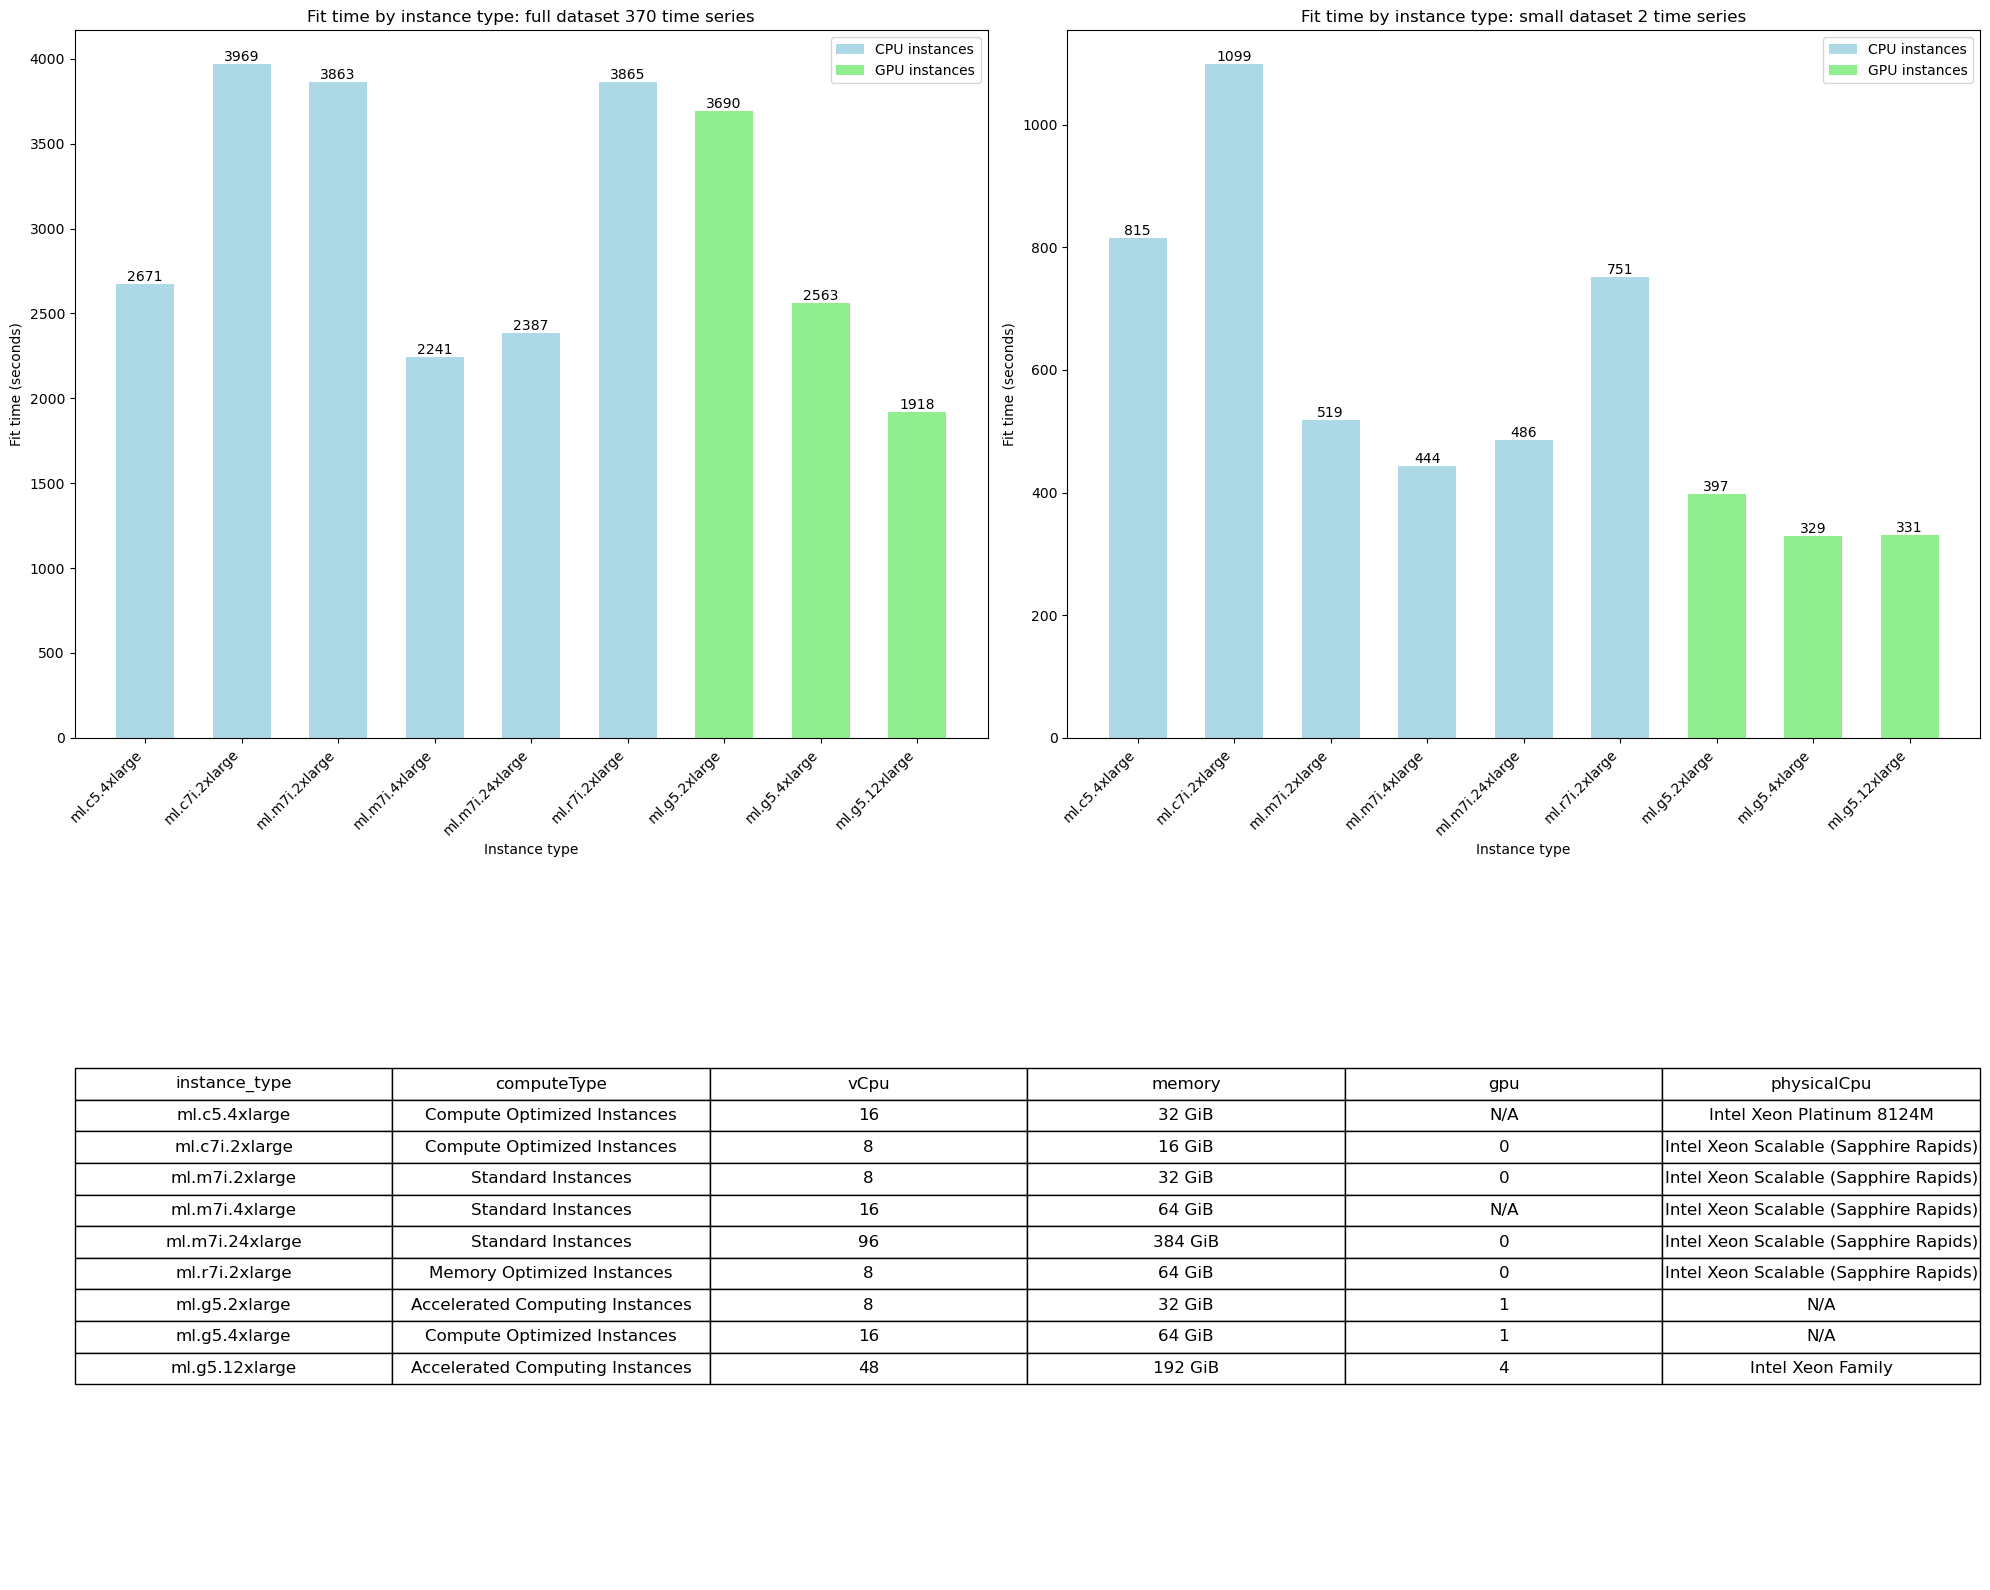

In [81]:
fig = plt.figure(figsize=(20, 16))
gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1])

# Create the subplots
ax1, ax2, ax3 = fig.add_subplot(gs[0, 0]), fig.add_subplot(gs[0, 1]), fig.add_subplot(gs[1, :])

create_bar_chart(ax1, data_cpu_full, data_gpu_full, f'Fit time by instance type: full dataset {data_kw.shape[1]} time series')
create_bar_chart(ax2, data_cpu_small, data_gpu_small, f'Fit time by instance type: small dataset {data_kw_small.shape[1]} time series')

ax3.axis('off')
table = ax3.table(cellText=instance_data_df.values, colLabels=instance_data_df.columns, loc='center', cellLoc='center')

# Adjust table style
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1, 1.5)

# Adjust layout to prevent clipping of tick-labels
plt.tight_layout()
plt.show()

In [ ]:
predictor.fit(
    train_data=train_df,
    # time_limit=30*60,
    presets="high_quality",
)

Beginning AutoGluon training...
AutoGluon will save models to 'autogluon-2H-370-17533-20240906-154012'
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.10.14
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Wed Aug 7 16:53:32 UTC 2024
CPU Count:          16
GPU Count:          0
Memory Avail:       21.75 GB / 30.34 GB (71.7%)
Disk Space Avail:   38.96 GB / 49.98 GB (78.0%)
Setting presets to: high_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': 'default',
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 84,
 'quantile_levels': [0.1, 0.5, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': False,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: '2h'
Provided train_data has 6456130 rows, 370 time series. Median time series length is 17449 (min=17449, max=174

## Working with trained predictor

After training completed, you can access all information via `TimeSeriesPredictor` class.

In [ ]:
# Detailed information about models trained
predictor.fit_summary()

In [ ]:
# Dictionary of model details
predictor.info()

See the AutoGluon documentation on the [`leaderboard()`](https://auto.gluon.ai/stable/api/autogluon.timeseries.TimeSeriesPredictor.leaderboard.html) method for description of each shown column.

In [43]:
# Model leaderboard with scoring
predictor.leaderboard()

,model,score_val,pred_time_val,fit_time_marginal,fit_order
0,WeightedEnsemble,-0.057191,184.665973,4.987585,12
1,TemporalFusionTransformer,-0.059416,3.416027,521.483837,9
2,DirectTabular,-0.060588,8.486868,369.670619,3
3,DeepAR,-0.062530,22.978817,237.244700,10
4,PatchTST,-0.064468,1.876810,83.499928,11
5,SeasonalNaive,-0.079946,2.978666,5.009495,1
6,AutoETS,-0.080037,144.928786,3.878561,7
7,AutoARIMA,-0.080757,443.423546,3.873699,8
8,RecursiveTabular,-0.098713,17.466769,642.183629,2
9,NPTS,-0.146398,47.209921,3.914600,5


In [ ]:
# You can provide a dataset to evaluate the model leaderboard based on the test data
predictor.leaderboard(test_df)

To load all saved predictor data including the model leaderboard, logs, and the trained model you use the [`load()`](https://auto.gluon.ai/stable/api/autogluon.timeseries.TimeSeriesPredictor.load.html) method of the `TimeSeriesPredictor` class.

In [39]:
# list all autogluon data saved to the EBS volume
!ls -dt {experiment_prefix}*/

autogluon-2H-2-17533-20240906-212951/
autogluon-2H-370-17533-20240905-214138/
autogluon-2H-2-17533-20240905-212320/
autogluon-2H-370-17533-20240905-080206/
autogluon-2H-370-17533-20240904-213220/


In [42]:
# uncomment if you need to load a predictor from the saved data
# predictor_data_path="autogluon-2H-370-17533-20240905-214138"
# predictor = TimeSeriesPredictor.load(predictor_data_path)

Loading predictor from path autogluon-2H-370-17533-20240905-214138


### Save the model performance to a file

In [47]:
os.makedirs("./model-performance", exist_ok=True)

In [43]:
metrics = ['WQL', 'MAPE', 'WAPE', 'RMSE', 'MASE']
# You can also specify a model name via `model` parameter
model_metrics = predictor.evaluate(
    data=test_df, 
    metrics=metrics, 
    # model="DeepAR", 
    display=True)

Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble
/opt/conda/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:15: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 12.0.1. Please consider upgrading.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)
2024-09-06 21:34:57.839107: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-06 21:34:57.839154: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to re

In [85]:
def display_and_save_metrics(
    model_metrics,
    experiment_name,
    timestamp=strftime("%Y%m%d-%H%M%S", gmtime()),
    display_only=False,
):
    model_metrics_df = pd.DataFrame.from_dict(model_metrics, orient='index', columns=['value']).reset_index().rename(columns={'index': 'metric_name'})
    model_metrics_df['experiment'] = experiment_name
    model_metrics_df['timestamp'] = timestamp
    # AutoGluon flipps the sign of a metric, multiply by -1
    model_metrics_df['value'] = model_metrics_df['value'] * (-1)
    model_metrics_df = model_metrics_df[['timestamp','metric_name','value','experiment']]

    print(model_metrics_df)

    if not display_only:
        model_metrics_df.to_csv(f'./model-performance/{experiment_name}-{timestamp}.csv', index=False)

    return model_metrics_df

In [86]:
display_and_save_metrics(model_metrics, experiment_name, timestamp)

         timestamp metric_name      value            experiment
0  20240906-225828         WQL   0.075033  autogluon-2H-2-17533
1  20240906-225828        MAPE   0.218210  autogluon-2H-2-17533
2  20240906-225828        WAPE   0.094401  autogluon-2H-2-17533
3  20240906-225828        RMSE  22.655883  autogluon-2H-2-17533
4  20240906-225828        MASE   1.427991  autogluon-2H-2-17533


,timestamp,metric_name,value,experiment
0,20240906-225828,WQL,0.075033,autogluon-2H-2-17533
1,20240906-225828,MAPE,0.218210,autogluon-2H-2-17533
2,20240906-225828,WAPE,0.094401,autogluon-2H-2-17533
3,20240906-225828,RMSE,22.655883,autogluon-2H-2-17533
4,20240906-225828,MASE,1.427991,autogluon-2H-2-17533


## Generate predictions and visualize

To generate predictions and to plot the results you use the methonds [`predict()`](https://auto.gluon.ai/stable/api/autogluon.timeseries.TimeSeriesPredictor.predict.html) and [`plot()`](https://auto.gluon.ai/stable/api/autogluon.timeseries.TimeSeriesPredictor.plot.html) of the `TimeSeriesPredictor`.

In [49]:
# persist models in memory for reduced inference latency
predictor.persist()

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


['TemporalFusionTransformer',
 'DeepAR',
 'WeightedEnsemble',
 'SeasonalNaive',
 'DirectTabular',
 'Chronos[base]',
 'NPTS',
 'PatchTST',
 'AutoETS']

In [50]:
prediction_df = predictor.predict(test_df)

Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


`predict()` method generates `prediction_length` starting from the end of the provided time series:

In [51]:
prediction_df

mean         0.1         0.5         0.9
item_id timestamp                                                          
MT_262  2015-01-01 02:00:00   81.098710   67.745069   84.626359   93.615039
        2015-01-01 04:00:00   96.699542   78.874395   99.295048  108.637616
        2015-01-01 06:00:00  156.789870  117.681086  159.866678  175.243275
        2015-01-01 08:00:00  185.420702  149.600803  187.697872  209.352313
        2015-01-01 10:00:00  186.734239  147.648938  189.042775  212.548721
...                                 ...         ...         ...         ...
MT_258  2015-01-07 16:00:00  145.375606  131.632256  145.447503  160.017932
        2015-01-07 18:00:00  142.415754  126.832472  142.771410  160.098848
        2015-01-07 20:00:00  116.211529  100.401762  116.469015  144.585458
        2015-01-07 22:00:00   75.555495   62.290941   75.650733   94.478347
        2015-01-08 00:00:00   47.727303   33.974554   47.675384   67.923967

[168 rows x 4 columns]

`plot()` method plots predictions together with historical time series and confidence interval based on forecast quantiles.

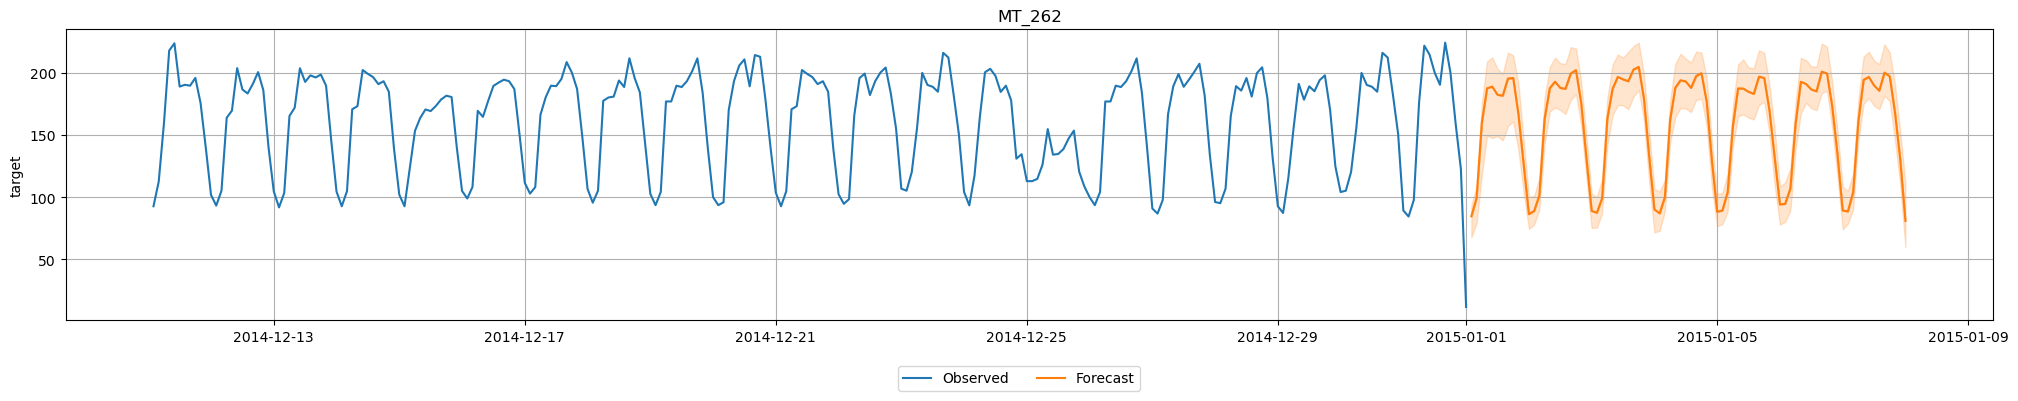

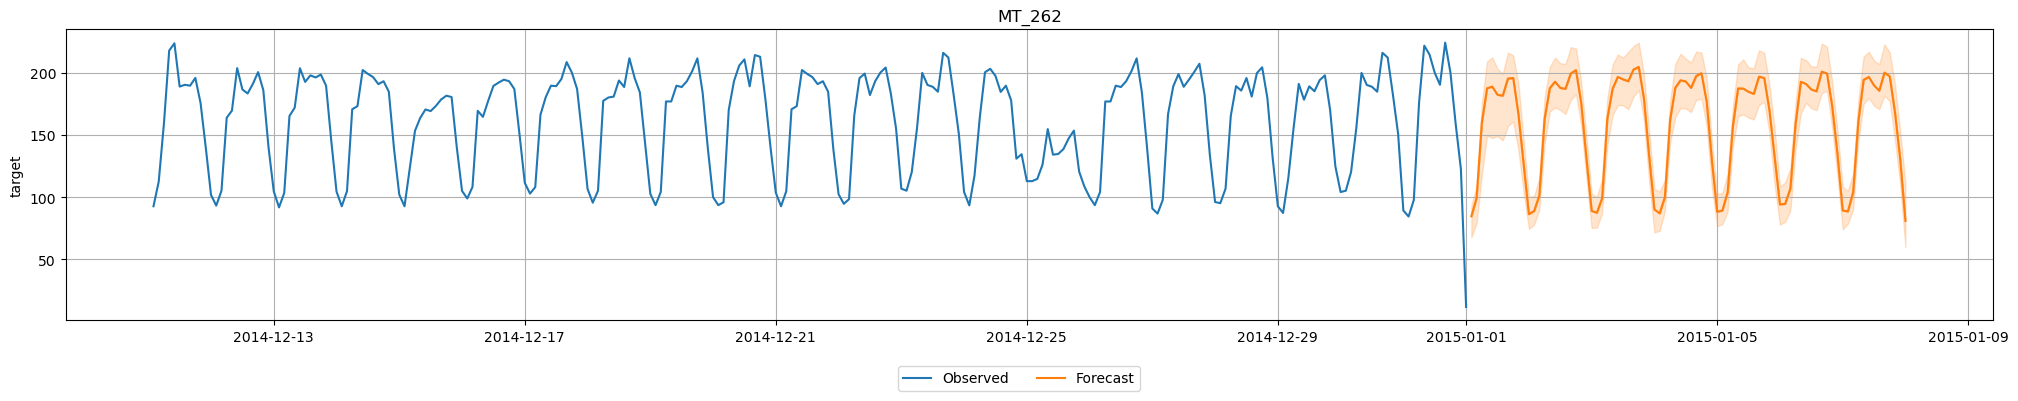

In [52]:
predictor.plot(
    data=test_df,
    predictions=prediction_df,
    quantile_levels=forecast_quantiles,
    item_ids=[prediction_df.index.get_level_values(0).unique().to_list()[0]],
    max_history_length=prediction_length*3,   
)

Experiment with different trained models and prediction dates to generate forecast. You can change the following parameters:

- `Model`: select any model from the predictor's leaderboard
- `Time series ids`: id of the time series to forecast. You can select multiple time series to plot together
- `Offset days`: how many days back from the data end the prediction starts
- `History lenght`: how many 'prediction lengths' of history are shown on the plot as the history series

In [53]:
style = {"description_width": "initial"}
ts_id_list = test_df.index.get_level_values(0).unique().to_list()

In [56]:
@interact_manual(
    model=Dropdown(options=predictor.leaderboard()['model'].to_list(), description='Model:'),
    ts_ids=SelectMultiple(options=ts_id_list,value=[ts_id_list[0]], style=style, description='Time series ids:'),
    offset_days=IntSlider(min=-365, max=0, value=0, style=style, description='Offset days:'),
    history_length=IntSlider(min=1, max=10, value=3, style=style, description='History length:'),
    continuous_update=False,
)
def plot_interact(
    model,
    ts_ids,
    offset_days,
    history_length,
):
    offset = -offset_days * intervals_per_day + 1
    data_end_index = offset - prediction_length + 1

    data_df = test_df.slice_by_timestep(end_index=-data_end_index) if offset > prediction_length else test_df
    inference_df = test_df.slice_by_timestep(end_index=-offset)
    prediction_df = predictor.predict(data=inference_df, model=model)
        
    predictor.plot(
        data=data_df,
        predictions=prediction_df,
        quantile_levels=forecast_quantiles,
        item_ids=list(ts_ids),
        max_history_length=history_length*prediction_length,   
    )

    plt.show()

interactive(children=(Dropdown(description='Model:', options=('WeightedEnsemble', 'TemporalFusionTransformer',…

---

## Optional: use Chronos with AutoGluon

<div class="alert alert-info">If you run this notebook on a CPU-only instance, you can use Chronos models <code>tiny</code> and <code>mini</code> only.</div>

Chronos on AutoGluon is available in five model sizes with different [numbers of parameters](https://github.com/amazon-science/chronos-forecasting/tree/main?tab=readme-ov-file#architecture): `tiny` (8M), `mini` (20M), `small` (46M), `base` (200M), and `large` (710M). 

Being a pretrained transformer model for zero-shot forecasting, Chronos is different from other models available in AutoGluon Time Series. Chronos models do not really fit time series data during training time with `fit()`. When `predict()` is called, it carries out a relatively more expensive computation that scales linearly with the number of time series in the dataset. In this aspect, they behave like local statistical models such as ETS or ARIMA, or generative AI foundation models where expensive computation happens during inference. Computation for `small`, `base`, and `large` Chronos models requires a GPU accelerator chip to run in a reasonable amount of time.

The easiest way to get started with Chronos is through model-specific presets available in the [`TimeSeriesPredictor.fit()`](https://auto.gluon.ai/stable/api/autogluon.timeseries.TimeSeriesPredictor.fit.html). As of v1.1, the `fit()` method has five specific Chronos preset for each model size, such as `chronos_small` or `chronos_base` and two Chronos-specific ensemble presets.

In ensemble mode Chronos is combined with other time series models using presets `chronos_ensemble` and `chronos_large_ensemble`. More details about these presets are available in the documentation for [`TimeSeriesPredictor.fit`](https://auto.gluon.ai/stable/api/autogluon.timeseries.TimeSeriesPredictor.fit.html).

Note that the model sizes `small` and higher require a GPU to run.

### Create a predictor
Create a `TimeSeriesPredictor` for Chronos usage.

In [65]:
train_df.shape

(34898, 1)

In [69]:
timestamp = strftime("%Y%m%d-%H%M%S", gmtime())
chronos_experiment_name = f"{experiment_prefix_chronos}-{freq}-{ts_wide_df.shape[1]}-{ts_wide_df.shape[0]}"
chronos_predictor_data_path = f"{chronos_experiment_name}-{timestamp}"

print(f"Experiment name: {chronos_experiment_name}")

Experiment name: autogluon-chronos-2H-2-17533


In [70]:
chronos_predictor = TimeSeriesPredictor(
    target="target",
    prediction_length=prediction_length,
    eval_metric=eval_metric,
    quantile_levels=forecast_quantiles,
    path=chronos_predictor_data_path, 
)

### Fit Chronos models

In [74]:
number_of_gpus = torch.cuda.device_count()
print(f"Number of GPUs available: {number_of_gpus}")

if number_of_gpus < 1:
    chronos_size = 'mini'
elif number_of_gpus == 1:
    chronos_size = 'base'
else:
    chronos_size = 'large'

Number of GPUs available: 1


In [76]:
chronos_predictor.fit(
    train_data=train_df,
    presets=f"chronos_{chronos_size}",
)

Beginning AutoGluon training...
AutoGluon will save models to 'autogluon-chronos-2H-2-17533-20240906-225828'
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.10.14
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Wed Aug 7 16:53:32 UTC 2024
CPU Count:          8
GPU Count:          1
Memory Avail:       26.58 GB / 30.99 GB (85.8%)
Disk Space Avail:   92.74 GB / 99.95 GB (92.8%)
Setting presets to: chronos_base

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'base'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 84,
 'quantile_levels': [0.1, 0.5, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: '2H'
Provided train_data has 34898 rows, 2 time series. Median time series length is

In [82]:
chronos_predictor.leaderboard()

,model,score_val,pred_time_val,fit_time_marginal,fit_order
0,Chronos[base],None,None,0.000325,1


As you can see, Chronos does not take any time to `fit`. The `fit` call still does some of tasks under the hood, such as inferring the frequency of time series and saving the predictor's state to disk.

### Generate predictions and visualize

Use the `predict()` method to generate forecasts, and the `plot()` method to visualize them.

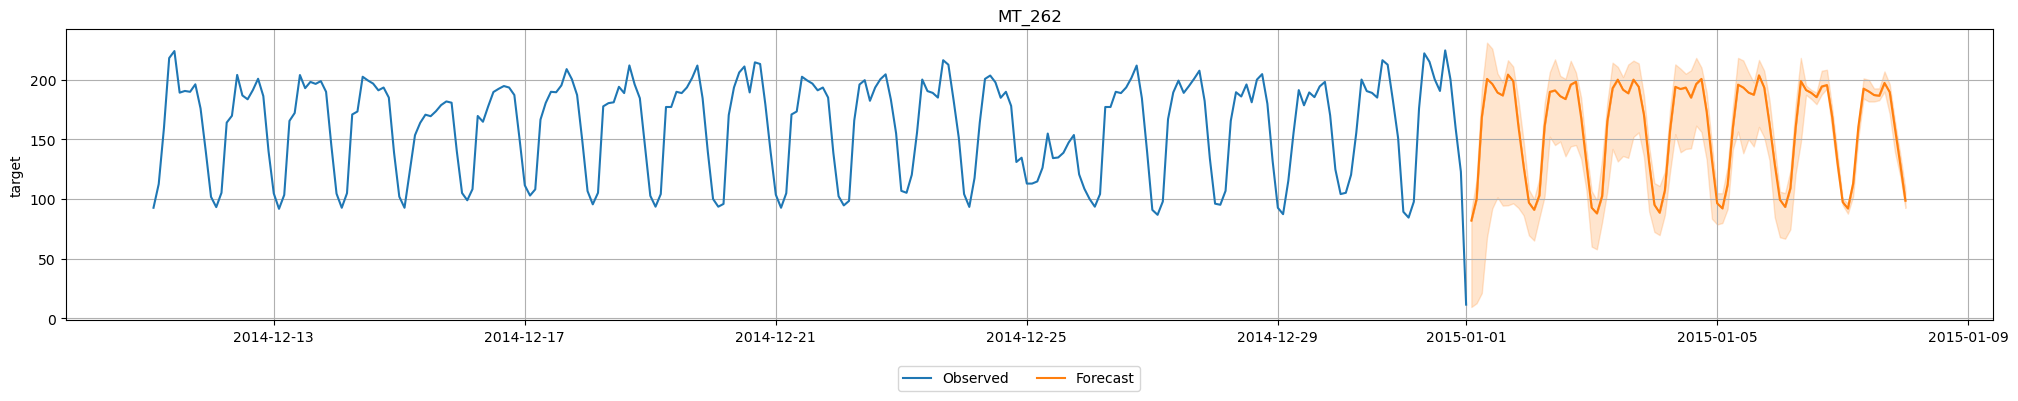

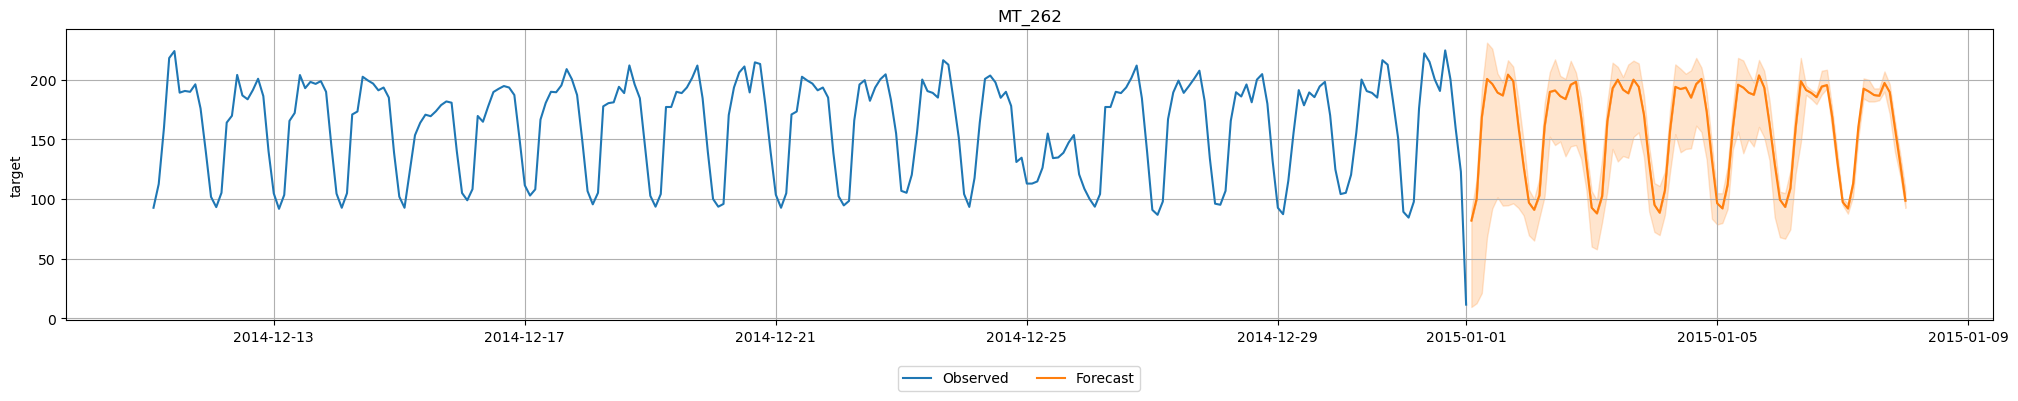

In [96]:
chronos_prediction_df = chronos_predictor.predict(test_df)

chronos_predictor.plot(
    data=test_df,
    predictions=chronos_prediction_df,
    quantile_levels=forecast_quantiles,
    item_ids=[chronos_prediction_df.index.get_level_values(0).unique().to_list()[0]],
    max_history_length=prediction_length*3,   
)

You can use the plotting function from the previous section to play with Chronos predictor for different time series and dates.

### Save the model performance to a file

In [84]:
chronos_model_metrics = chronos_predictor.evaluate(
    data=test_df, 
    metrics=metrics, 
    display=True)

Model not specified in predict, will default to the model with the best validation score: Chronos[base]
Evaluations on test data:
{
    "WQL": -0.08564498259254916,
    "MAPE": -0.23637591506043754,
    "WAPE": -0.1109613669484518,
    "RMSE": -23.813708824988286,
    "MASE": -1.6732613399228693
}


In [87]:
display_and_save_metrics(chronos_model_metrics, chronos_experiment_name, timestamp)

         timestamp metric_name      value                    experiment
0  20240906-225828         WQL   0.085645  autogluon-chronos-2H-2-17533
1  20240906-225828        MAPE   0.236376  autogluon-chronos-2H-2-17533
2  20240906-225828        WAPE   0.110961  autogluon-chronos-2H-2-17533
3  20240906-225828        RMSE  23.813709  autogluon-chronos-2H-2-17533
4  20240906-225828        MASE   1.673261  autogluon-chronos-2H-2-17533


,timestamp,metric_name,value,experiment
0,20240906-225828,WQL,0.085645,autogluon-chronos-2H-2-17533
1,20240906-225828,MAPE,0.236376,autogluon-chronos-2H-2-17533
2,20240906-225828,WAPE,0.110961,autogluon-chronos-2H-2-17533
3,20240906-225828,RMSE,23.813709,autogluon-chronos-2H-2-17533
4,20240906-225828,MASE,1.673261,autogluon-chronos-2H-2-17533


### Configuring for performance

As with all large deep learning models some fine-grained control of inference parameters can be needed to both optimize the speed and avoid out-of-memory issues on specific hardware. For this, we will need to dive a bit deeper, configuring `hyperparameters` of the `TimeSeriesPredictor` directly.

In [88]:
chronos_cpu_predictor = TimeSeriesPredictor(prediction_length=prediction_length).fit(
    train_df,
    hyperparameters={
        "Chronos": {
            "model_path": "mini",
            "batch_size": 64,
            "device": "cpu"
        }
    },
    skip_model_selection=True,
    verbosity=0,
)

In [89]:
%%time
predictions = chronos_cpu_predictor.predict(test_df)

config.json:   0%|          | 0.00/1.11k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/81.8M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/142 [00:00<?, ?B/s]

CPU times: user 37.3 s, sys: 14.1 s, total: 51.5 s
Wall time: 13.9 s


You used the following configuration options for the `TimeSeriesPredictor`:
- `skip_model_selection=True` to skip running backtests during `fit`, as you use a single model only.
- in the `hyperparameters` for the Chronos model,
    - `model_path` allows to change the model size or select different pretrained weights. This parameter can be a model string like `tiny` or `base`, a Hugging Face path like `amazon/chronos-t5-mini`, or a path to a local folder with custom weights.
    - `batch_size` configures the number of time series for which predictions are generated in parallel.
    - `device` instructs Chronos to run the model on CPU.

You can see that inference speed is slower on the CPU compared to the GPU. To improve inference speed AutoGluon implementation of Chronos supports several deep learning compilers that can optimize model performance on CPUs.

For example, you can set `optimization_strategy="openvino"` to use the [OpenVINO](https://github.com/openvinotoolkit/openvino) compiler for Intel CPUs to speed up Chronos inference. Behind the scenes, AutoGluon will use Hugging Face [optimum](https://github.com/huggingface/optimum-intel) for this conversion.

Note that this requires installing the optional OpenVINO dependency for AutoGluon Time Series.

In [90]:
!pip install -q "autogluon.timeseries[chronos-openvino]"

To speed up the inference even further, we can `persist` the model after calling `fit`. The `TimeSeriesPredictor.persist()` method tells AutoGluon to keep the Chronos model in device memory for fast, on-demand inference instead of loading the model from disk each time.

In [94]:
%%capture
fast_chronos_cpu_predictor = TimeSeriesPredictor(prediction_length=prediction_length).fit(
    train_df,
    hyperparameters={
        "Chronos": {
            "model_path": "tiny",
            "batch_size": 64,
            "device": "cpu",
            "optimization_strategy": "openvino",
        }
    },
    skip_model_selection=True,
    verbosity=0,
)
predictor.persist()

In [95]:
%%time
predictions = fast_chronos_cpu_predictor.predict(test_df)

CPU times: user 22.6 s, sys: 971 ms, total: 23.6 s
Wall time: 10.8 s


Depending on your environment and the used JupyterLab App instance you might see an increase in inference time.

You can also use the ONNX runtime by providing `optimization_strategy="onnx"`. For a discussion of these and other hyperparameters of Chronos, see the Chronos model [documentation](forecasting-model-zoo.md).

### Further Chronos experiments

You can use another Chronos-specific presets as described in the [`TimeSeriesPredictor.fit()`](https://auto.gluon.ai/stable/api/autogluon.timeseries.TimeSeriesPredictor.fit.html) documentation:
- `chronos_ensemble`: builds an ensemble of seasonal naive, tree-based and deep learning models with fast inference and `chronos_small`.    
- `chronos_large_ensemble`: builds an ensemble of seasonal naive, tree-based and deep learning models with fast inference and `chronos_large`.

Feel free to experiment with these presets using code from this notebook.

<div class="alert alert-info">Note you can use these presets to fit models and run inference on GPU instances only.</div>

---

## Clean up

In [ ]:
# free memory
predictor.unpersist()

## Shutdown kernel

In [ ]:
%%html

<p><b>Shutting down your kernel for this notebook to release resources.</b></p>
<button class="sm-command-button" data-commandlinker-command="kernelmenu:shutdown" style="display:none;">Shutdown Kernel</button>
        
<script>
try {
    els = document.getElementsByClassName("sm-command-button");
    els[0].click();
}
catch(err) {
    // NoOp
}    
</script>